Project 3 data cleaning

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as scs
import numpy as np
import datetime
import seaborn as sns

from sklearn import svm, datasets
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier,KNeighborsRegressor
from sklearn.model_selection import train_test_split, learning_curve, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler, label_binarize, LabelEncoder
from visualize import generate_moons_df, preprocess, plot_boundaries

from sklearn.datasets import make_classification
from sklearn.metrics import plot_confusion_matrix, confusion_matrix, plot_roc_curve, \
classification_report, mean_squared_error, r2_score, auc, \
precision_score, recall_score, precision_recall_curve,f1_score, fbeta_score, roc_curve
from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance

from xgboost import XGBClassifier
from xgboost import plot_importance
import xgboost as xgb

# Importing data

In [4]:
DC = pd.read_csv('dc-wikia-data.csv')
marvel = pd.read_csv('marvel-wikia-data.csv')

# Combining tables

Do the column names match?

In [5]:
for x,y in zip(DC.columns, marvel.columns):
    print(x == y)

True
True
True
True
True
True
True
True
True
True
True
True
False


Not quite.

In [6]:
DC.columns[-1], marvel.columns[-1]

('YEAR', 'Year')

In [7]:
marvel.rename(columns = {'Year': 'YEAR'}, inplace = True)

marvel.columns

Index(['page_id', 'name', 'urlslug', 'ID', 'ALIGN', 'EYE', 'HAIR', 'SEX',
       'GSM', 'ALIVE', 'APPEARANCES', 'FIRST APPEARANCE', 'YEAR'],
      dtype='object')

In [8]:
marvel['is_marvel'] = 1
DC['is_marvel'] = 0

marvel.head()

,page_id,name,urlslug,ID,ALIGN,EYE,HAIR,SEX,GSM,ALIVE,APPEARANCES,FIRST APPEARANCE,YEAR,is_marvel
0,1678,Spider-Man (Peter Parker),\/Spider-Man_(Peter_Parker),Secret Identity,Good Characters,Hazel Eyes,Brown Hair,Male Characters,NaN,Living Characters,4043.0,Aug-62,1962.0,1
1,7139,Captain America (Steven Rogers),\/Captain_America_(Steven_Rogers),Public Identity,Good Characters,Blue Eyes,White Hair,Male Characters,NaN,Living Characters,3360.0,Mar-41,1941.0,1
2,64786,"Wolverine (James \""Logan\"" Howlett)",\/Wolverine_(James_%22Logan%22_Howlett),Public Identity,Neutral Characters,Blue Eyes,Black Hair,Male Characters,NaN,Living Characters,3061.0,Oct-74,1974.0,1
3,1868,"Iron Man (Anthony \""Tony\"" Stark)",\/Iron_Man_(Anthony_%22Tony%22_Stark),Public Identity,Good Characters,Blue Eyes,Black Hair,Male Characters,NaN,Living Characters,2961.0,Mar-63,1963.0,1
4,2460,Thor (Thor Odinson),\/Thor_(Thor_Odinson),No Dual Identity,Good Characters,Blue Eyes,Blond Hair,Male Characters,NaN,Living Characters,2258.0,Nov-50,1950.0,1


Let's combine 'em!

In [9]:
df = pd.concat([marvel, DC], ignore_index=True, sort=False)

In [10]:
df.shape

(23272, 14)

# EDA and cleaning

In [223]:
df.dtypes

page_id               int64
name                 object
urlslug              object
ID                   object
ALIGN                object
EYE                  object
HAIR                 object
SEX                  object
GSM                  object
ALIVE                object
APPEARANCES         float64
FIRST APPEARANCE     object
YEAR                float64
is_marvel             int64
dtype: object

## Nulls?

In [224]:
df.isnull().sum()

page_id                 0
name                    0
urlslug                 0
ID                   5783
ALIGN                3413
EYE                 13395
HAIR                 6538
SEX                   979
GSM                 23118
ALIVE                   6
APPEARANCES          1451
FIRST APPEARANCE      884
YEAR                  884
is_marvel               0
dtype: int64

## Replacing nulls

Appearances - who are the most important characters?

In [225]:
df.APPEARANCES.describe()

count    21821.000000
mean        19.009303
std         93.814040
min          1.000000
25%          1.000000
50%          4.000000
75%         10.000000
max       4043.000000
Name: APPEARANCES, dtype: float64

This suggests that there are few characters who appear A LOT and a lot of minor characters that have not appeared very often.

In [226]:
df.APPEARANCES.median()

4.0

How many characters occur more than 1000 times?

In [227]:
len(df.loc[(df.APPEARANCES > 1000), 'name'])

42

In [ ]:
MF = df.loc[(df['SEX']=='Male Characters')|(df['SEX']=='Female Characters')]

sns.barplot(x='SEX', y = 'APPEARANCES', data = MF)
plt.title('Character gender count', size = 15)
plt.xlabel('Gender')
plt.ylabel('Avg number of appearances')
plt.xticks(rotation=0)


In [229]:
df.loc[df['SEX'] == 'Transgender Characters', 'name']

20253    Daystar (New Earth)
Name: name, dtype: object

### ID column

In [230]:
df['ID'].isnull().sum()

5783

In [231]:
df[df['ID'].isnull()==True]

,page_id,name,urlslug,ID,ALIGN,EYE,HAIR,SEX,GSM,ALIVE,APPEARANCES,FIRST APPEARANCE,YEAR,is_marvel
467,2028,Arthur Parks (Earth-616),\/Arthur_Parks_(Earth-616),NaN,Bad Characters,Variable Eyes,Variable Hair,Male Characters,NaN,Living Characters,88.0,Nov-66,1966.0,1
536,65598,Kathryn Cushing (Earth-616),\/Kathryn_Cushing_(Earth-616),NaN,NaN,Blue Eyes,Blond Hair,Female Characters,NaN,Living Characters,72.0,Nov-85,1985.0,1
573,2159,Calvin Rankin (Earth-616),\/Calvin_Rankin_(Earth-616),NaN,Good Characters,Brown Eyes,Brown Hair,Male Characters,NaN,Living Characters,67.0,Apr-66,1966.0,1
577,2526,Shadow King (Earth-616),\/Shadow_King_(Earth-616),NaN,Bad Characters,Red Eyes,No Hair,Male Characters,NaN,Living Characters,67.0,Jan-79,1979.0,1
605,16087,Arthur Stacy (Earth-616),\/Arthur_Stacy_(Earth-616),NaN,Good Characters,Blue Eyes,Grey Hair,Male Characters,NaN,Living Characters,63.0,Feb-71,1971.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23250,128098,Bartholomew Magan (New Earth),\/wiki\/Bartholomew_Magan_(New_Earth),NaN,Bad Characters,NaN,NaN,Male Characters,NaN,Living Characters,NaN,"1963, September",1963.0,0
23251,22325,James Moon (New Earth),\/wiki\/James_Moon_(New_Earth),NaN,NaN,NaN,NaN,Male Characters,NaN,Living Characters,NaN,"1962, March",1962.0,0
23254,34617,Dorothea Tane (New Earth),\/wiki\/Dorothea_Tane_(New_Earth),NaN,NaN,NaN,Blond Hair,Female Characters,NaN,Living Characters,NaN,"1948, August",1948.0,0
23255,238641,Dmane (Earth-Two),\/wiki\/Dmane_(Earth-Two),NaN,Bad Characters,Blue Eyes,NaN,Male Characters,NaN,Living Characters,NaN,"1946, April",1946.0,0


In [232]:
df['ID'] = df['ID'].replace(np.nan, 'NA')

### GSM column

In [233]:
DC.GSM.value_counts()

Homosexual Characters    54
Bisexual Characters      10
Name: GSM, dtype: int64

In [234]:
df['GSM'] = df['GSM'].replace(np.nan, 'Not_minority')

### Align column

In [235]:
df.head()

,page_id,name,urlslug,ID,ALIGN,EYE,HAIR,SEX,GSM,ALIVE,APPEARANCES,FIRST APPEARANCE,YEAR,is_marvel
0,1678,Spider-Man (Peter Parker),\/Spider-Man_(Peter_Parker),Secret Identity,Good Characters,Hazel Eyes,Brown Hair,Male Characters,Not_minority,Living Characters,4043.0,Aug-62,1962.0,1
1,7139,Captain America (Steven Rogers),\/Captain_America_(Steven_Rogers),Public Identity,Good Characters,Blue Eyes,White Hair,Male Characters,Not_minority,Living Characters,3360.0,Mar-41,1941.0,1
2,64786,"Wolverine (James \""Logan\"" Howlett)",\/Wolverine_(James_%22Logan%22_Howlett),Public Identity,Neutral Characters,Blue Eyes,Black Hair,Male Characters,Not_minority,Living Characters,3061.0,Oct-74,1974.0,1
3,1868,"Iron Man (Anthony \""Tony\"" Stark)",\/Iron_Man_(Anthony_%22Tony%22_Stark),Public Identity,Good Characters,Blue Eyes,Black Hair,Male Characters,Not_minority,Living Characters,2961.0,Mar-63,1963.0,1
4,2460,Thor (Thor Odinson),\/Thor_(Thor_Odinson),No Dual Identity,Good Characters,Blue Eyes,Blond Hair,Male Characters,Not_minority,Living Characters,2258.0,Nov-50,1950.0,1


In [236]:
df['ALIGN'] = df['ALIGN'].replace(np.nan, 'no allegiance')

### Eye column

In [239]:
df['EYE'].value_counts()

Blue Eyes             3064
Brown Eyes            2803
Black Eyes             967
Green Eyes             904
Red Eyes               716
White Eyes             516
Yellow Eyes            342
Grey Eyes              135
Hazel Eyes              99
Variable Eyes           49
Photocellular Eyes      48
Purple Eyes             45
Orange Eyes             35
Pink Eyes               27
Gold Eyes               23
Violet Eyes             23
One Eye                 21
Amber Eyes              15
Silver Eyes             12
No Eyes                  7
Multiple Eyes            7
Auburn Hair              7
Yellow Eyeballs          6
Black Eyeballs           3
Magenta Eyes             2
Compound Eyes            1
Name: EYE, dtype: int64

In [240]:
df['EYE'] = df['EYE'].replace(np.nan, 'no color')

### Hair column

In [242]:
df['HAIR'] = df['HAIR'].replace(np.nan, 'no color')

### Sex (nice)

In [244]:
df.SEX.value_counts()

Male Characters           16421
Female Characters          5804
Agender Characters           45
Genderless Characters        20
Genderfluid Characters        2
Transgender Characters        1
Name: SEX, dtype: int64

In [246]:
df.loc[df['SEX'].isnull()]

,page_id,name,urlslug,ID,ALIGN,EYE,HAIR,SEX,GSM,ALIVE,APPEARANCES,FIRST APPEARANCE,YEAR,is_marvel
182,15511,Phoenix Force (Earth-616),\/Phoenix_Force_(Earth-616),Secret Identity,Neutral Characters,no color,No Hair,NaN,Not_minority,Deceased Characters,229.0,Oct-76,1976.0,1
380,2300,Prosh (Earth-616),\/Prosh_(Earth-616),Secret Identity,Good Characters,Variable Eyes,No Hair,NaN,Not_minority,Living Characters,109.0,Jan-88,1988.0,1
409,1526,Eternity (Earth-616),\/Eternity_(Earth-616),Secret Identity,Neutral Characters,Black Eyes,No Hair,NaN,Not_minority,Living Characters,100.0,Nov-65,1965.0,1
608,16580,Microtron (Earth-616),\/Microtron_(Earth-616),NA,no allegiance,no color,no color,NaN,Not_minority,Living Characters,63.0,Jan-79,1979.0,1
659,392309,Korr (Moloid) (Earth-616),\/Korr_(Moloid)_(Earth-616),Secret Identity,Good Characters,no color,No Hair,NaN,Not_minority,Living Characters,58.0,Mar-10,2010.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23056,185733,Dungeon (New Earth),\/wiki\/Dungeon_(New_Earth),NA,Bad Characters,no color,no color,NaN,Not_minority,Living Characters,NaN,"1996, April",1996.0,0
23107,185321,Doctor Vortex (New Earth),\/wiki\/Doctor_Vortex_(New_Earth),NA,Bad Characters,no color,no color,NaN,Not_minority,Living Characters,NaN,"1993, December",1993.0,0
23112,192434,Quote (New Earth),\/wiki\/Quote_(New_Earth),NA,Bad Characters,no color,no color,NaN,Not_minority,Living Characters,NaN,"1993, December",1993.0,0
23211,144269,M'Dahna (New Earth),\/wiki\/M%27Dahna_(New_Earth),Secret Identity,Good Characters,Brown Eyes,no color,NaN,Not_minority,Living Characters,NaN,"1981, June",1981.0,0


In [248]:
df['SEX'] = df['SEX'].replace(np.nan, 'NA')

### Alive column

In [250]:
df.loc[df['ALIVE'].isnull()]

,page_id,name,urlslug,ID,ALIGN,EYE,HAIR,SEX,GSM,ALIVE,APPEARANCES,FIRST APPEARANCE,YEAR,is_marvel
16293,541449,Mj7711,\/User:Mj7711,NA,no allegiance,no color,no color,NA,Not_minority,NaN,NaN,NaN,NaN,1
16329,714409,Sharjeel786,\/User:Sharjeel786,NA,no allegiance,no color,no color,NA,Not_minority,NaN,NaN,NaN,NaN,1
16347,462671,TOR\/test,\/User:TOR\/test,NA,no allegiance,no color,no color,NA,Not_minority,NaN,NaN,NaN,NaN,1
19102,263678,Hatshephut II (New Earth),\/wiki\/Hatshephut_II_(New_Earth),Public Identity,Bad Characters,no color,no color,Female Characters,Not_minority,NaN,8.0,"1992, November",1992.0,0
19626,293107,Leander (New Earth),\/wiki\/Leander_(New_Earth),Public Identity,Good Characters,no color,Blue Hair,Male Characters,Homosexual Characters,NaN,6.0,"1997, January",1997.0,0
23230,285581,Mrblonde267\/Buddy Blank (New Earth),\/wiki\/User:Mrblonde267\/Buddy_Blank_(New_Earth),NA,no allegiance,no color,no color,NA,Not_minority,NaN,NaN,"1974, October",1974.0,0


In [251]:
df['ALIVE'] = df['ALIVE'].replace(np.nan, 'NA')

### Appearances column

In [253]:
df.loc[df['APPEARANCES'].isnull()].head()

,page_id,name,urlslug,ID,ALIGN,EYE,HAIR,SEX,GSM,ALIVE,APPEARANCES,FIRST APPEARANCE,YEAR,is_marvel
15280,743309,Minister of Castile D'or (Earth-616),\/Minister_of_Castile_D%27or_(Earth-616),No Dual Identity,Neutral Characters,no color,no color,Male Characters,Not_minority,Deceased Characters,NaN,Dec-39,1939.0,1
15281,645438,Mr. Harris' Secretary (Earth-616),\/Mr._Harris%27_Secretary_(Earth-616),No Dual Identity,Neutral Characters,no color,Blond Hair,Female Characters,Not_minority,Living Characters,NaN,Oct-39,1939.0,1
15282,331151,N'Jaga (Earth-616),\/N%27Jaga_(Earth-616),No Dual Identity,Bad Characters,no color,no color,Male Characters,Not_minority,Living Characters,NaN,Oct-39,1939.0,1
15283,505986,Ertve (Earth-616),\/Ertve_(Earth-616),Secret Identity,Good Characters,Blue Eyes,White Hair,Male Characters,Not_minority,Living Characters,NaN,Feb-40,1940.0,1
15284,19657,Invisible Man (Gade) (Earth-616),\/Invisible_Man_(Gade)_(Earth-616),Secret Identity,Good Characters,no color,no color,Male Characters,Not_minority,Living Characters,NaN,Apr-40,1940.0,1


Let's replace NaN's in appearances with simple "1" -- these characters are likely not that important.

In [254]:
df['APPEARANCES'] = df['APPEARANCES'].replace(np.nan, 1)

### First appearance column

In [258]:
df.loc[df['FIRST APPEARANCE'].isnull()].head()

,page_id,name,urlslug,ID,ALIGN,EYE,HAIR,SEX,GSM,ALIVE,APPEARANCES,FIRST APPEARANCE,YEAR,is_marvel
12,7823,Namor McKenzie (Earth-616),\/Namor_McKenzie_(Earth-616),No Dual Identity,Neutral Characters,Green Eyes,Black Hair,Male Characters,Not_minority,Living Characters,1528.0,NaN,NaN,1
38,1677,Rogue (Anna Marie) (Earth-616),\/Rogue_(Anna_Marie)_(Earth-616),Secret Identity,Good Characters,Green Eyes,Auburn Hair,Female Characters,Not_minority,Living Characters,850.0,NaN,NaN,1
80,67048,Blaine Colt (Earth-616),\/Blaine_Colt_(Earth-616),Public Identity,no allegiance,Blue Eyes,Blond Hair,Male Characters,Not_minority,Deceased Characters,429.0,NaN,NaN,1
114,37751,Monica Rambeau (Earth-616),\/Monica_Rambeau_(Earth-616),Secret Identity,Good Characters,Brown Eyes,Black Hair,Female Characters,Not_minority,Living Characters,327.0,NaN,NaN,1
259,25255,James Bradley (Earth-616),\/James_Bradley_(Earth-616),Secret Identity,Good Characters,Blue Eyes,Black Hair,Male Characters,Not_minority,Living Characters,158.0,NaN,NaN,1


It is weird that some of these characters have NaN's here...let's replace them with "unknown" for now.

In [259]:
df['FIRST APPEARANCE'] = df['FIRST APPEARANCE'].replace(np.nan, 'Unknown')

### Year column

Same treatment as first appearance - these columns seem connected.

In [261]:
df['YEAR'] = df['YEAR'].replace(np.nan, 'Unknown')

In [262]:
df.isnull().sum()

page_id             0
name                0
urlslug             0
ID                  0
ALIGN               0
EYE                 0
HAIR                0
SEX                 0
GSM                 0
ALIVE               0
APPEARANCES         0
FIRST APPEARANCE    0
YEAR                0
is_marvel           0
dtype: int64

No more nulls!

In [755]:
df.head()

,page_id,name,urlslug,ID,ALIGN,EYE,HAIR,SEX,GSM,ALIVE,APPEARANCES,FIRST APPEARANCE,YEAR,is_marvel
0,1678,Spider-Man (Peter Parker),\/Spider-Man_(Peter_Parker),Secret Identity,Good Characters,Hazel Eyes,Brown Hair,Male Characters,Not_minority,Living Characters,4043.0,Aug-62,1962,1
1,7139,Captain America (Steven Rogers),\/Captain_America_(Steven_Rogers),Public Identity,Good Characters,Blue Eyes,White Hair,Male Characters,Not_minority,Living Characters,3360.0,Mar-41,1941,1
2,64786,"Wolverine (James \""Logan\"" Howlett)",\/Wolverine_(James_%22Logan%22_Howlett),Public Identity,Neutral Characters,Blue Eyes,Black Hair,Male Characters,Not_minority,Living Characters,3061.0,Oct-74,1974,1
3,1868,"Iron Man (Anthony \""Tony\"" Stark)",\/Iron_Man_(Anthony_%22Tony%22_Stark),Public Identity,Good Characters,Blue Eyes,Black Hair,Male Characters,Not_minority,Living Characters,2961.0,Mar-63,1963,1
4,2460,Thor (Thor Odinson),\/Thor_(Thor_Odinson),No Dual Identity,Good Characters,Blue Eyes,Blond Hair,Male Characters,Not_minority,Living Characters,2258.0,Nov-50,1950,1


In [765]:
df['YEAR'].value_counts()

Unknown    884
1993.0     763
1994.0     715
2006.0     684
1992.0     633
          ... 
1958.0      17
1938.0      10
1936.0       9
1937.0       4
1935.0       1
Name: YEAR, Length: 80, dtype: int64

## Visualizing gategorical vars

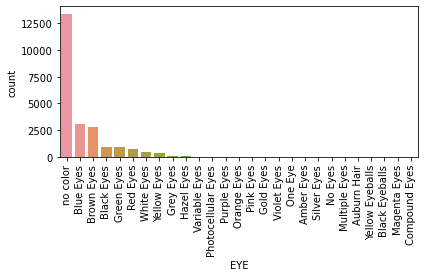

In [263]:
g=sns.countplot(x='EYE', data=df, order = df['EYE'].value_counts().index) # sns.displot(df, x="EYE")
plt.xticks(rotation=90)
plt.tight_layout();

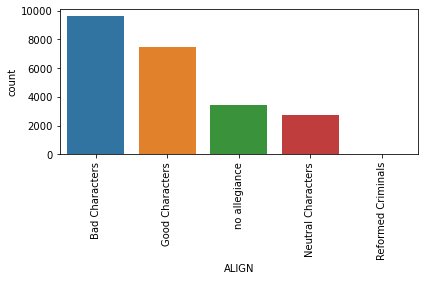

In [264]:
g=sns.countplot(x='ALIGN', data=df, order = df['ALIGN'].value_counts().index) # sns.displot(df, x="EYE")
plt.xticks(rotation=90)
plt.tight_layout();

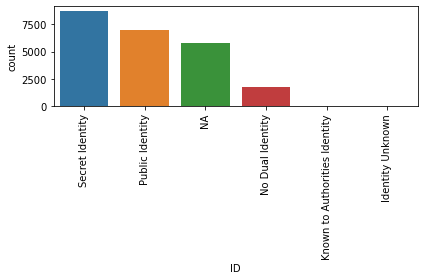

In [265]:
g=sns.countplot(x='ID', data=df, order = df['ID'].value_counts().index) # sns.displot(df, x="EYE")
plt.xticks(rotation=90)
plt.tight_layout();

In [150]:
df.columns

Index(['page_id', 'name', 'urlslug', 'ID', 'ALIGN', 'EYE', 'HAIR', 'SEX',
       'GSM', 'ALIVE', 'APPEARANCES', 'FIRST APPEARANCE', 'YEAR', 'is_marvel'],
      dtype='object')

### Need to fix 'FIRST APPEARANCE' column - later

In [69]:
pd.to_datetime(DC['FIRST APPEARANCE'][1])

Timestamp('1986-10-01 00:00:00')

In [70]:
marvel['FIRST APPEARANCE'] = pd.to_datetime(marvel['FIRST APPEARANCE'], format='%b-%y')

In [266]:
marvel['FIRST APPEARANCE'].head()

0    Aug-62
1    Mar-41
2    Oct-74
3    Mar-63
4    Nov-50
Name: FIRST APPEARANCE, dtype: object

In [79]:
for x in marvel['FIRST APPEARANCE'].head():
    if x.year > 2020:
        year = int(x.year - 100)
    else:
        year = x.year
    print(datetime.date(year,x.month,x.day))

1962-08-01
1941-03-01
1974-10-01
1963-03-01
1950-11-01


In [ ]:
def fix_date(x):
    if x.year > 2020:
        year = x.year - 100
    else:
        year = x.year
    return datetime.date(year,x.month,x.day)


marvel['FIRST APPEARANCE'] = marvel['FIRST APPEARANCE'].apply(fix_date)

In [86]:
marvel['FIRST APPEARANCE'][:5].apply(fix_date)

0    1962-08-01
1    1941-03-01
2    1974-10-01
3    1963-03-01
4    1950-11-01
Name: FIRST APPEARANCE, dtype: object

In [47]:
marvel['FIRST APPEARANCE'][0].year

2062

# Features and target

## Issue 1: "Black eyeballs" and "Compound eyes" are screwing up the transformation

In [273]:

df.loc[(df['EYE'] == 'Compound Eyes')|(df['EYE'] == 'Black Eyeballs')]

,page_id,name,urlslug,ID,ALIGN,EYE,HAIR,SEX,GSM,ALIVE,APPEARANCES,FIRST APPEARANCE,YEAR,is_marvel
52,1680,Remy LeBeau (Earth-616),\/Remy_LeBeau_(Earth-616),Secret Identity,Good Characters,Black Eyeballs,Brown Hair,Male Characters,Not_minority,Living Characters,636.0,Jul-90,1990,1
183,15907,Megan Gwynn (Earth-616),\/Megan_Gwynn_(Earth-616),Public Identity,Good Characters,Black Eyeballs,Pink Hair,Female Characters,Not_minority,Living Characters,229.0,Nov-04,2004,1
6836,320831,Mrs. Gwynn (Earth-616),\/Mrs._Gwynn_(Earth-616),Public Identity,Neutral Characters,Black Eyeballs,Pink Hair,Female Characters,Not_minority,Living Characters,4.0,Apr-10,2010,1
7272,165697,Lepirax (Earth-616),\/Lepirax_(Earth-616),NA,Bad Characters,Compound Eyes,no color,Male Characters,Not_minority,Living Characters,3.0,Nov-77,1977,1


In [277]:
df['EYE'] = df['EYE'].replace(['Black Eyeballs', 'Magenta Eyes', 'Compound Eyes'], ['Black Eyes', 'Purple Eyes', 'Multiple Eyes'])

In [278]:
df['EYE'].value_counts()

no color              13395
Blue Eyes              3064
Brown Eyes             2803
Black Eyes              970
Green Eyes              904
Red Eyes                716
White Eyes              516
Yellow Eyes             342
Grey Eyes               135
Hazel Eyes               99
Variable Eyes            49
Photocellular Eyes       48
Purple Eyes              47
Orange Eyes              35
Pink Eyes                27
Violet Eyes              23
Gold Eyes                23
One Eye                  21
Amber Eyes               15
Silver Eyes              12
Multiple Eyes             8
No Eyes                   7
Auburn Hair               7
Yellow Eyeballs           6
Name: EYE, dtype: int64

## Issue 2: "Dyed Hair" is screwing up the transformation

In [289]:
df['HAIR'] = df['HAIR'].replace(["Reddish Brown Hair",'Orange-brown Hair', 'Platinum Blond Hair', 'Bronze Hair', 'Dyed Hair'], ['Brown Hair', 'Brown Hair','Blond Hair', 'Blond Hair', 'Variable Hair'])

In [290]:
df['HAIR'].value_counts()

no color                 6538
Black Hair               5329
Brown Hair               3493
Blond Hair               2329
No Hair                  1176
White Hair               1100
Red Hair                 1081
Bald                      838
Grey Hair                 688
Green Hair                159
Blue Hair                  97
Purple Hair                79
Auburn Hair                78
Strawberry Blond Hair      75
Orange Hair                64
Pink Hair                  42
Variable Hair              33
Yellow Hair                20
Silver Hair                19
Gold Hair                  13
Reddish Blond Hair          6
Light Brown Hair            6
Magenta Hair                5
Violet Hair                 4
Name: HAIR, dtype: int64

## Issue 3: "Genderfluid Characters" is screwing up the transformation

In [301]:
df.loc[df['SEX'] == 'Transgender Characters']

,page_id,name,urlslug,ID,ALIGN,EYE,HAIR,SEX,GSM,ALIVE,APPEARANCES,FIRST APPEARANCE,YEAR,is_marvel
20253,317067,Daystar (New Earth),\/wiki\/Daystar_(New_Earth),NA,Bad Characters,no color,no color,Transgender Characters,Not_minority,Deceased Characters,4.0,"2009, October",2009,0


In [316]:
df['SEX'] = df['SEX'].replace(['Genderless Characters', 'Genderfluid Characters', 'Transgender Characters'], ['Agender Characters', 'Agender Characters', 'Agender Characters'])

In [317]:
df['SEX'].value_counts()

Male Characters       16421
Female Characters      5804
NA                      979
Agender Characters       68
Name: SEX, dtype: int64

## Issue 4: "Transvestites" (also who uses that word)

In [357]:
df['GSM'].value_counts()

Not_minority              23118
Homosexual Characters       120
Bisexual Characters          29
Transgender Characters        2
Pansexual Characters          1
Genderfluid Characters        1
Transvestites                 1
Name: GSM, dtype: int64

In [361]:
df.loc[df['GSM'] == 'Transvestites']

,page_id,name,urlslug,ID,ALIGN,EYE,HAIR,SEX,GSM,ALIVE,APPEARANCES,FIRST APPEARANCE,YEAR,is_marvel
71,1409,Deadpool (Wade Wilson),\/Deadpool_(Wade_Wilson),Secret Identity,Neutral Characters,Brown Eyes,Bald,Male Characters,Transvestites,Living Characters,500.0,Feb-91,1991,1


In [362]:
df['GSM'] = df['GSM'].replace(['Transgender Characters', 'Pansexual Characters', 'Genderfluid Characters', 'Transvestites'], ['Other', 'Other','Other','Other'])

## Selecting features

### Cleaning our Y

In [384]:
df['ALIGN'].value_counts()

Bad Characters        9615
Good Characters       7468
no allegiance         3413
Neutral Characters    2773
Reformed Criminals       3
Name: ALIGN, dtype: int64

In [385]:
df.loc[df['ALIGN'] == 'Reformed Criminals']

,page_id,name,urlslug,ID,ALIGN,EYE,HAIR,SEX,GSM,ALIVE,APPEARANCES,FIRST APPEARANCE,YEAR,is_marvel
16763,1523,Owen Mercer (New Earth),\/wiki\/Owen_Mercer_(New_Earth),Secret Identity,Reformed Criminals,Blue Eyes,Red Hair,Male Characters,Not_minority,Deceased Characters,78.0,"2004, October",2004,0
19665,344298,Brian Elliot (New Earth),\/wiki\/Brian_Elliot_(New_Earth),Public Identity,Reformed Criminals,no color,Blond Hair,Male Characters,Not_minority,Living Characters,6.0,"1993, May",1993,0
19975,201316,Paula von Gunther (New Earth),\/wiki\/Paula_von_Gunther_(New_Earth),NA,Reformed Criminals,Blue Eyes,Blond Hair,Female Characters,Not_minority,Living Characters,5.0,"1998, March",1998,0


In [386]:
df['ALIGN'] = df['ALIGN'].replace(['no allegiance', 'Reformed Criminals'], ['Neutral Characters', 'Neutral Characters'])

# Looking at feature distribution across classes

In [11]:
df[df['ALIGN'] == 'Good Characters'].head(30)

,page_id,name,urlslug,ID,ALIGN,EYE,HAIR,SEX,GSM,ALIVE,APPEARANCES,FIRST APPEARANCE,YEAR,is_marvel
0,1678,Spider-Man (Peter Parker),\/Spider-Man_(Peter_Parker),Secret Identity,Good Characters,Hazel Eyes,Brown Hair,Male Characters,NaN,Living Characters,4043.0,Aug-62,1962.0,1
1,7139,Captain America (Steven Rogers),\/Captain_America_(Steven_Rogers),Public Identity,Good Characters,Blue Eyes,White Hair,Male Characters,NaN,Living Characters,3360.0,Mar-41,1941.0,1
3,1868,"Iron Man (Anthony \""Tony\"" Stark)",\/Iron_Man_(Anthony_%22Tony%22_Stark),Public Identity,Good Characters,Blue Eyes,Black Hair,Male Characters,NaN,Living Characters,2961.0,Mar-63,1963.0,1
4,2460,Thor (Thor Odinson),\/Thor_(Thor_Odinson),No Dual Identity,Good Characters,Blue Eyes,Blond Hair,Male Characters,NaN,Living Characters,2258.0,Nov-50,1950.0,1
5,2458,Benjamin Grimm (Earth-616),\/Benjamin_Grimm_(Earth-616),Public Identity,Good Characters,Blue Eyes,No Hair,Male Characters,NaN,Living Characters,2255.0,Nov-61,1961.0,1
6,2166,Reed Richards (Earth-616),\/Reed_Richards_(Earth-616),Public Identity,Good Characters,Brown Eyes,Brown Hair,Male Characters,NaN,Living Characters,2072.0,Nov-61,1961.0,1
7,1833,Hulk (Robert Bruce Banner),\/Hulk_(Robert_Bruce_Banner),Public Identity,Good Characters,Brown Eyes,Brown Hair,Male Characters,NaN,Living Characters,2017.0,May-62,1962.0,1
9,1837,Jonathan Storm (Earth-616),\/Jonathan_Storm_(Earth-616),Public Identity,Good Characters,Blue Eyes,Blond Hair,Male Characters,NaN,Living Characters,1934.0,Nov-61,1961.0,1
10,15725,Henry McCoy (Earth-616),\/Henry_McCoy_(Earth-616),Public Identity,Good Characters,Blue Eyes,Blue Hair,Male Characters,NaN,Living Characters,1825.0,Sep-63,1963.0,1
11,1863,Susan Storm (Earth-616),\/Susan_Storm_(Earth-616),Public Identity,Good Characters,Blue Eyes,Blond Hair,Female Characters,NaN,Living Characters,1713.0,Nov-61,1961.0,1


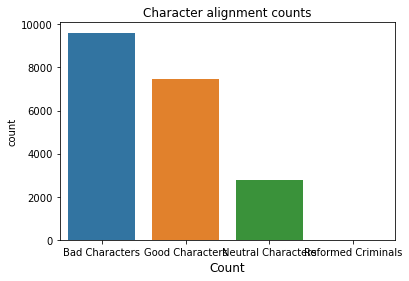

In [12]:
g=sns.countplot(x='ALIGN', data=df, order = df['ALIGN'].value_counts().index) # sns.displot(df, x="EYE")
plt.xticks(rotation=0)
plt.xlabel('Character alignment', size = 12)
plt.xlabel('Count', size = 12)
plt.title('Character alignment counts');

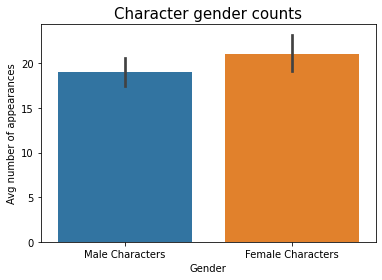

In [13]:
MF = df.loc[(df['SEX']=='Male Characters')|(df['SEX']=='Female Characters')]

sns.barplot(x='SEX', y = 'APPEARANCES', data = MF)
plt.title('Character gender counts', size = 15)
plt.xlabel('Gender')
plt.ylabel('Avg number of appearances')
plt.xticks(rotation=0);


/Users/noah/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


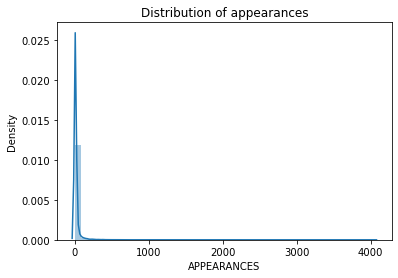

In [14]:
sns.distplot(df['APPEARANCES'])
plt.title('Distribution of appearances');

# Exporting

In [754]:
filename = 'superhero_data_for_model_10-20-20_PICKLE'
outfile = open(filename,'wb')
pickle.dump(df,outfile)
outfile.close()


In [15]:
df.to_csv(r'superhero_10-26-20.csv')

## and only characters with >200 appearances

In [29]:
df.sort_values(by='APPEARANCES', ascending=False).head(100)

,page_id,name,urlslug,ID,ALIGN,EYE,HAIR,SEX,GSM,ALIVE,APPEARANCES,FIRST APPEARANCE,YEAR,is_marvel
0,1678,Spider-Man (Peter Parker),\/Spider-Man_(Peter_Parker),Secret Identity,Good Characters,Hazel Eyes,Brown Hair,Male Characters,NaN,Living Characters,4043.0,Aug-62,1962.0,1
1,7139,Captain America (Steven Rogers),\/Captain_America_(Steven_Rogers),Public Identity,Good Characters,Blue Eyes,White Hair,Male Characters,NaN,Living Characters,3360.0,Mar-41,1941.0,1
16376,1422,Batman (Bruce Wayne),\/wiki\/Batman_(Bruce_Wayne),Secret Identity,Good Characters,Blue Eyes,Black Hair,Male Characters,NaN,Living Characters,3093.0,"1939, May",1939.0,0
2,64786,"Wolverine (James \""Logan\"" Howlett)",\/Wolverine_(James_%22Logan%22_Howlett),Public Identity,Neutral Characters,Blue Eyes,Black Hair,Male Characters,NaN,Living Characters,3061.0,Oct-74,1974.0,1
3,1868,"Iron Man (Anthony \""Tony\"" Stark)",\/Iron_Man_(Anthony_%22Tony%22_Stark),Public Identity,Good Characters,Blue Eyes,Black Hair,Male Characters,NaN,Living Characters,2961.0,Mar-63,1963.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,6194,James Rhodes (Earth-616),\/James_Rhodes_(Earth-616),Secret Identity,Good Characters,Brown Eyes,Brown Hair,Male Characters,NaN,Living Characters,525.0,Jan-79,1979.0,1
66,1487,Timothy Dugan (Earth-616),\/Timothy_Dugan_(Earth-616),Public Identity,Good Characters,Blue Eyes,Red Hair,Male Characters,NaN,Deceased Characters,517.0,May-63,1963.0,1
16406,1455,Joker (New Earth),\/wiki\/Joker_(New_Earth),Secret Identity,Bad Characters,Green Eyes,Green Hair,Male Characters,NaN,Living Characters,517.0,"1940, June",1940.0,0
68,1613,Samuel Wilson (Earth-616),\/Samuel_Wilson_(Earth-616),Public Identity,Good Characters,Brown Eyes,Black Hair,Male Characters,NaN,Living Characters,512.0,Sep-69,1969.0,1


In [31]:
df_200appear = df.loc[df['APPEARANCES'] >= 200]

In [32]:
df_200appear.to_csv(r'df_200appear_10-27-20.csv')

In [37]:
df_top50 = df.sort_values(by = 'APPEARANCES', ascending=False).head(50)

In [39]:
df_top50.shape

(50, 14)

In [40]:
df_top50.to_csv(r'df_top50_10-27-20.csv')